In [1]:
%load_ext autoreload
%autoreload 2


In [64]:
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [95]:
import os

import torch
import torch.utils.data
from vis_det.model_pool.centernet.opts import opts
from vis_det.model_pool.centernet.models.model import create_model, load_model, save_model
from vis_det.model_pool.centernet.models.data_parallel import DataParallel
from vis_det.model_pool.centernet.logger import Logger
from vis_det.model_pool.centernet.datasets.dataset_factory import get_dataset
from vis_det.model_pool.centernet.trains.train_factory import train_factory
import matplotlib.pyplot as plt

In [15]:
opt = opts().parse()
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)

Fix size testing.
training chunk_sizes: [1]
The output will be saved to  /home/paritosh/Desktop/SEM2/16824/code/vlr-project/vis_det/vis_det/model_pool/centernet/../../exp/ddd/default
heads {'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2}
Namespace(task='ddd', dataset='kitti', exp_id='default', test=False, debug=0, demo='', load_model='/data/datasets/paritosh/16824/centernet/ddd_3dop.pth', resume=False, gpus=[0], num_workers=4, not_cuda_benchmark=False, seed=317, print_iter=0, hide_data_time=False, save_all=False, metric='loss', vis_thresh=0.3, debugger_theme='white', arch='dla_34', head_conv=256, down_ratio=4, input_res=1280, input_h=384, input_w=1280, lr=0.000125, lr_step=[90, 120], num_epochs=140, batch_size=1, master_batch_size=1, num_iters=-1, val_intervals=5, trainval=False, flip_test=False, test_scales=[1.0], nms=False, K=100, not_prefetch_test=False, fix_res=True, keep_res=False, not_rand_crop=False, shift=0.1, scale=0.4, rotate=0, flip=0.5, no_color_aug=False, aug_rot

In [16]:
opt.chunk_sizes

[1]

In [17]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
model, optimizer, start_epoch = load_model(
      model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)

val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True
  )

loaded /data/datasets/paritosh/16824/centernet/ddd_3dop.pth, epoch 70
==> initializing kitti 3dop, val data.
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Loaded val 3769 samples


In [18]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing kitti 3dop, train data.
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Loaded train 3712 samples


In [66]:
torch.device("cuda")

device(type='cuda')

In [75]:
count = 0
for iter_id, batch in enumerate(train_loader):
    count += 1
    #print(batch)
    initial_img = batch['input']
    trainer.infer(batch, torch.device("cuda"), 200)
    if count == 1:
        break
    

cuda
iter = 0, loss=13.912898063659668
iter = 50, loss=2.380199432373047
iter = 100, loss=1.4599828720092773
iter = 150, loss=1.4452766180038452


In [90]:
final_img = batch['input']

In [91]:
def display_img(img):
    img = img.squeeze().detach().cpu()
    img_disp = img.permute(1,2,0)
    plt.imshow(img_disp*255)

In [87]:
final_img

tensor([[[[-0.0083, -0.0083,  0.2021,  ..., -0.0083, -0.0083,  0.0989],
          [ 0.1627, -0.0083,  0.2147,  ..., -0.0083, -0.0083, -0.0083],
          [-0.0083, -0.0083,  0.3428,  ...,  0.3102,  0.0074,  0.3194],
          ...,
          [ 0.0891,  0.1172,  0.0414,  ...,  0.0753,  0.2003, -0.0083],
          [-0.0083,  0.3268,  0.0331,  ..., -0.0083,  0.1933,  0.5141],
          [-0.0083,  0.0623, -0.0083,  ..., -0.0083, -0.0083,  0.3413]],

         [[ 0.1314, -0.0080, -0.0080,  ..., -0.0080,  0.0864,  0.2807],
          [ 0.0052,  0.1697,  0.2473,  ..., -0.0060, -0.0080, -0.0080],
          [-0.0080, -0.0080,  0.1300,  ..., -0.0080, -0.0080, -0.0080],
          ...,
          [-0.0080,  0.0615,  0.0170,  ...,  0.3343,  0.1192,  0.0667],
          [-0.0080, -0.0080,  0.3631,  ..., -0.0080,  0.0153,  0.0105],
          [ 0.0399,  0.1165, -0.0080,  ..., -0.0080, -0.0080,  0.0930]],

         [[ 0.2545, -0.0071,  0.2929,  ...,  0.0015,  0.0221,  0.1218],
          [-0.0071, -0.0071,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


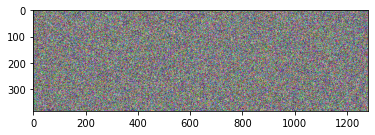

In [92]:
display_img(final_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


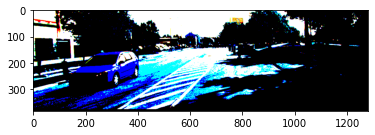

In [94]:
display_img(original_img)